# Clustering Hyperparameters Search: Ganglion Cells in the Retina

- **Author:** David Felipe
- **Contact:** https://github.com/davidnfu0
- **Last Modification:** January 25, 2024
- **Description:** In this document, we will conduct an exploratory data analysis to determine the optimal hyperparameters for clustering models.

## Introduction

### Importing Libraries

In [1]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [2]:
sys.path.append("../../")

In [3]:
from scripts import load_yaml_config, hide_warnings
from scripts.clustering import (
    plot_elbow_method,
    plot_knee_method,
    plot_silhouette_scores,
    gmm_bic_score,
    find_best_param,
    params_table,
    plot_dendrogram,
)

c:\Users\David\miniconda3\envs\ganglion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Paths and configuration

In [4]:
plt.style.use("seaborn-v0_8-darkgrid")

In [5]:
configPath = "../../config/"
config = load_yaml_config(configPath + "general_config.yml")

### Loading the Data

In [6]:
with open("../.." + config["paths"]["data_cache"]["clustering"]["DFS"], "rb") as file:
    dfs = pickle.load(file)
with open(
    "../.." + config["paths"]["data_cache"]["clustering"]["DFS_NORM"], "rb"
) as file:
    dfs_norm = pickle.load(file)

## Identifying Optimal Hyperparameters

### Elbow Method
In this section, we will apply the elbow method to estimate the optimal number of clusters for the K-Means algorithm. The elbow method is a heuristic used in cluster analysis to determine the number of clusters in a dataset. The idea is to run k-means clustering on the dataset for a range of values of k (number of clusters), and for each value of k compute the sum of squared distances from each point to its assigned center. When these overall distances are plotted against the number of clusters, the "elbow" of the curve represents a point where adding more clusters doesn't give much better modeling of the data. This point is considered to be a good estimate of the number of clusters.

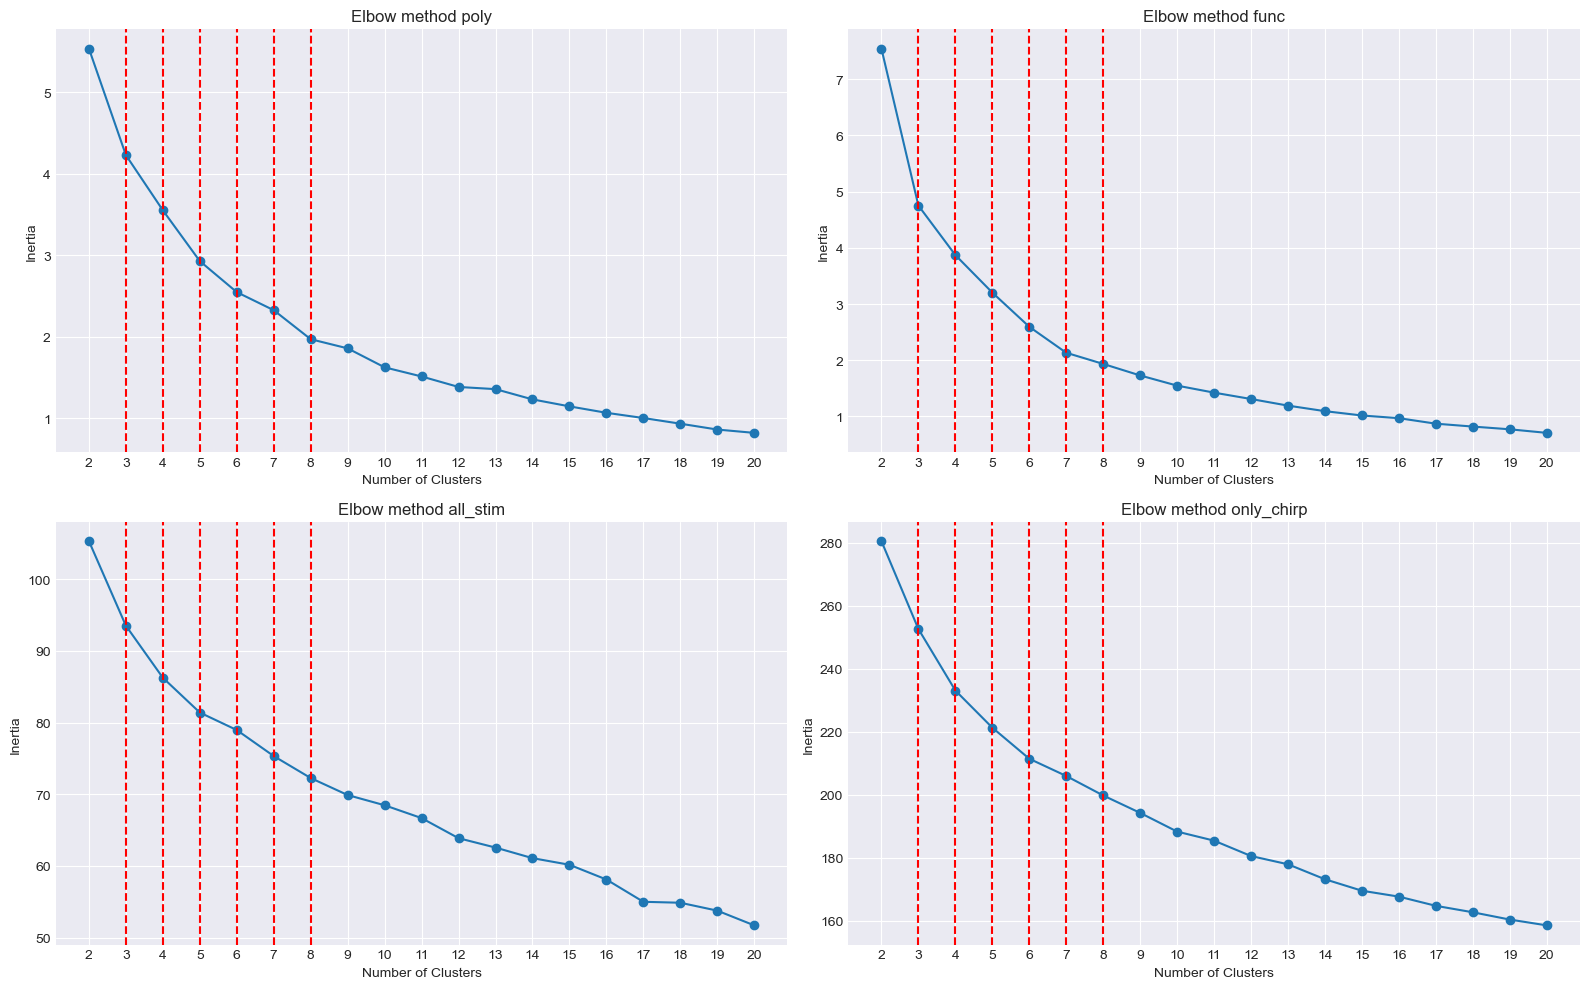

In [7]:
hide_warnings()
columns = 2 if len(dfs_norm) > 1 else 1
rows = int(np.ceil(len(dfs_norm) / columns))
plot_number = 1
figure_size = (columns * 8, rows * 5)
cluster_range = range(2, 21)
vertical_lines = [3, 4, 5, 6, 7, 8]
_, axs = plt.subplots(nrows=rows, ncols=columns, figsize=figure_size)
for df_name, data in dfs_norm.items():
    subplot_row = (plot_number - 1) // columns
    subplot_column = (plot_number - 1) % columns
    plot_elbow_method(
        title=f"Elbow method {df_name}",
        axs=axs,
        X=data,
        cluster_range=cluster_range,
        subplot_coords=(subplot_row, subplot_column),
        vertical_lines=vertical_lines,
    )
    plot_number += 1
plt.tight_layout()
plt.show()

### Silhouette Score
Now, to complement the information obtained from the elbow method, we will examine the silhouette coefficient to determine an optimal number of clusters for K-Means. The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. The silhouette score provides an insightful way to assess the quality of the clustering process.

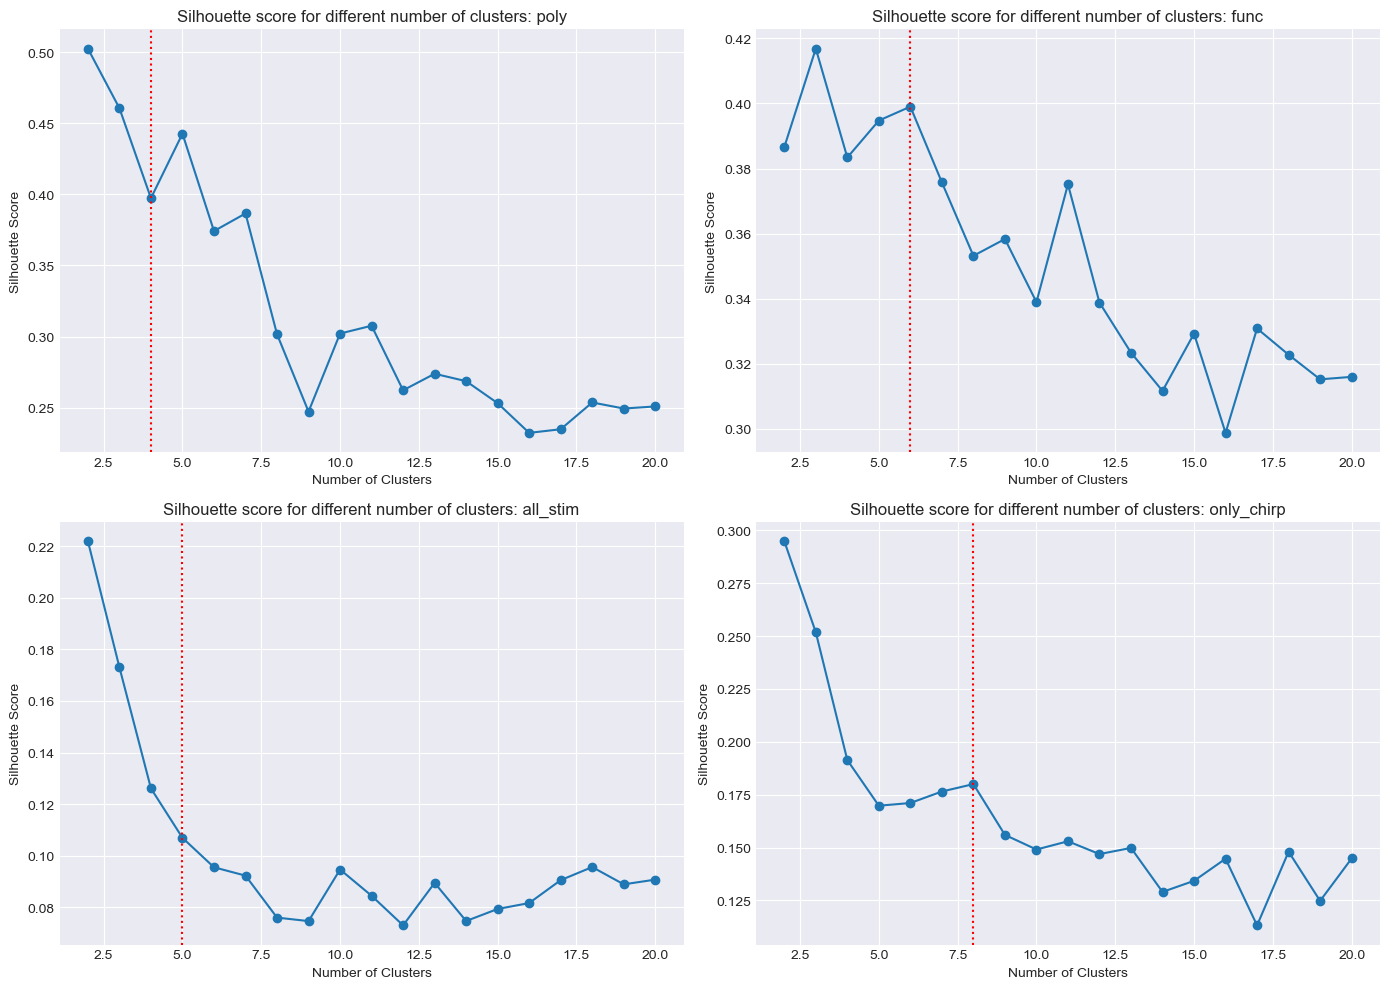

In [8]:
hide_warnings()
columns = 2 if len(dfs_norm) > 1 else 1
rows = int(np.ceil(len(dfs) / columns))
plot_number = 1
figure_size = (columns * 7, rows * 5)
cluster_range = range(2, 21)
k_means_n_clusters = {
    "poly": 4,
    "func": 6,
    "all_frames": 6,
    "all_stim": 5,
    "only_chirp": 8,
}
_, axs = plt.subplots(nrows=rows, ncols=columns, figsize=figure_size)
for df_name, data in dfs_norm.items():
    subplot_row = (plot_number - 1) // columns
    subplot_column = (plot_number - 1) % columns
    plot_silhouette_scores(
        title=f"Silhouette score for different number of clusters: {df_name}",
        X=data,
        axs=axs,
        cluster_range=cluster_range,
        subplot_coords=(subplot_row, subplot_column),
        vertical_line=k_means_n_clusters[df_name],
    )
    plot_number += 1
plt.tight_layout()
plt.show()

### Knee Method
In this section, we will implement the knee method to determine the optimal hyperparameters for the DBSCAN model. The knee method, also known as the knee point detection method, is a technique used to identify the point of rapid change in a curve, which is often referred to as the "knee" of the curve. In the context of DBSCAN (Density-Based Spatial Clustering of Applications with Noise), it is used to determine an appropriate value for the epsilon (ε) parameter, which defines the maximum distance between two points for them to be considered as part of the same cluster. The method involves plotting a sorted list of the distances of points to their nearest neighbors and looking for the point where the rate of increase in distance is sharpest. This point is considered as an indicator of the right ε value for DBSCAN, ensuring good balance between the cluster size and the number of clusters.

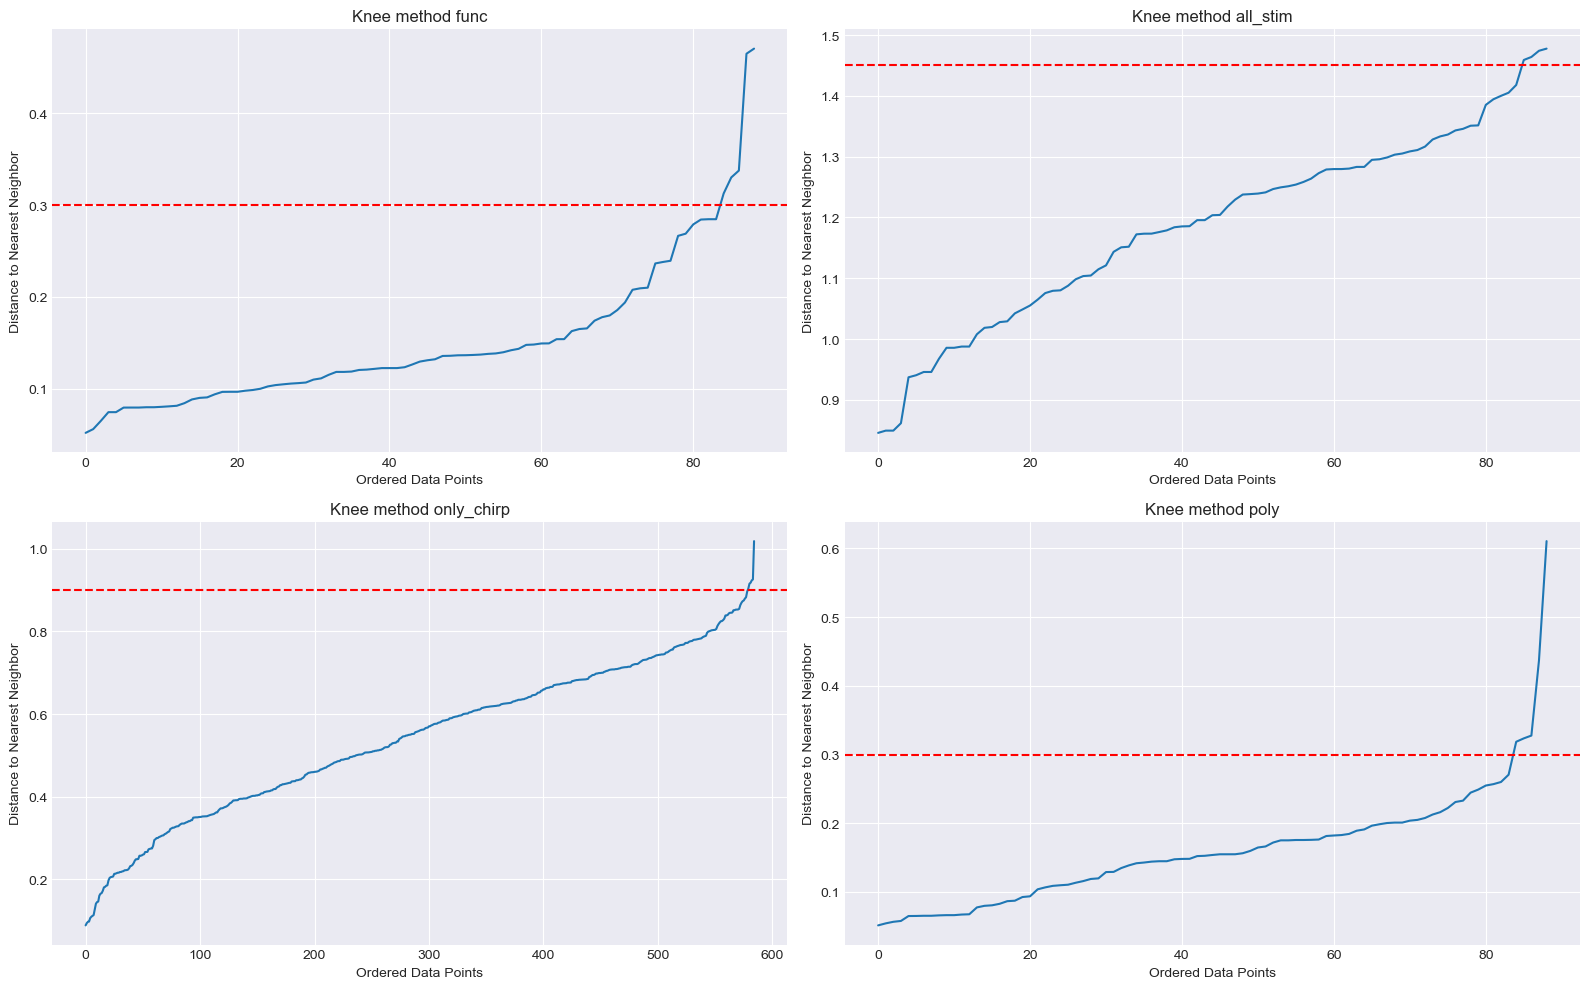

In [9]:
hide_warnings()
columns = 2 if len(dfs_norm) > 1 else 1
rows = int(np.ceil(len(dfs) / columns))
plot_number = 0
figure_size = (columns * 8, rows * 5)
dbscan_eps = {
    "poly": 0.3,
    "func": 0.3,
    "all_frames": 1,
    "all_stim": 1.45,
    "only_chirp": 0.9,
}
min_samples = 5
_, axs = plt.subplots(ncols=columns, nrows=rows, figsize=figure_size)
for df_name, data in dfs_norm.items():
    subplot_row = (plot_number - 1) // columns
    subplot_column = (plot_number - 1) % columns
    plot_knee_method(
        title=f"Knee method {df_name}",
        X=data,
        axs=axs,
        neighbors=min_samples,
        subplot_coords=(subplot_row, subplot_column),
        y_line=dbscan_eps[df_name],
    )
    plot_number += 1
plt.tight_layout()
plt.show()

### Grid Search for GMM Parameters
We will now perform a Grid Search to determine the hyperparameters that minimize the Bayesian Information Criterion (BIC). The Bayesian Information Criterion (BIC) is a criterion for model selection among a finite set of models. It is based on the likelihood function and is closely related to the Akaike Information Criterion (AIC). The BIC is particularly used in the context of model selection where the goal is to choose the best model from a set of candidates. It introduces a penalty term for the number of parameters in the model, thus discouraging overfitting. In mathematical terms, BIC is computed as BIC = ln(n) * k - 2 * ln(L), where n is the number of data points, k is the number of parameters, and L is the maximized value of the likelihood function for the model. A lower BIC indicates a better model, balancing the model complexity with the goodness of fit.

In [10]:
gmm_param_grid = {
    "n_components": range(4, 15),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

gmm_search_grid = dict()

for df_name, data in dfs_norm.items():
    gmm_search_grid[df_name] = find_best_param(
        model=GaussianMixture(),
        X=data,
        param_grid=gmm_param_grid,
        scoring=gmm_bic_score,
    )

    print(df_name)
    print(params_table(gmm_search_grid[df_name]).head(3))
    print("\n")

poly
  param_n_components param_covariance_type  mean_test_score
0                  4             spherical      -100.576414
1                  5             spherical       -73.262604
2                  6             spherical       -59.402417


func
   param_n_components param_covariance_type  mean_test_score
0                   4             spherical       -66.062676
1                   5             spherical       -48.717117
22                  4                  diag       -30.237622


all_stim
   param_n_components param_covariance_type  mean_test_score
22                  4                  diag     -1057.005166
0                   4             spherical      -885.415972
1                   5             spherical      -731.174176


only_chirp
   param_n_components param_covariance_type  mean_test_score
22                  4                  diag    -17950.902026
23                  5                  diag    -17437.789316
24                  6                  diag    -16878

### Dendrogram
In this section, we will plot dendrograms to determine the best hyperparameters for the agglomerative clustering model. Dendrograms are visual representations used in hierarchical clustering to illustrate the arrangement of the clusters produced by the process. In agglomerative clustering, each data point starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy. The dendrogram shows the sequence of cluster merges and the distance at which each merge occurs. By analyzing the dendrogram, one can choose a distance level that determines the number of clusters. It's a valuable tool for understanding the data structure and deciding on the optimal number of clusters for agglomerative clustering models.

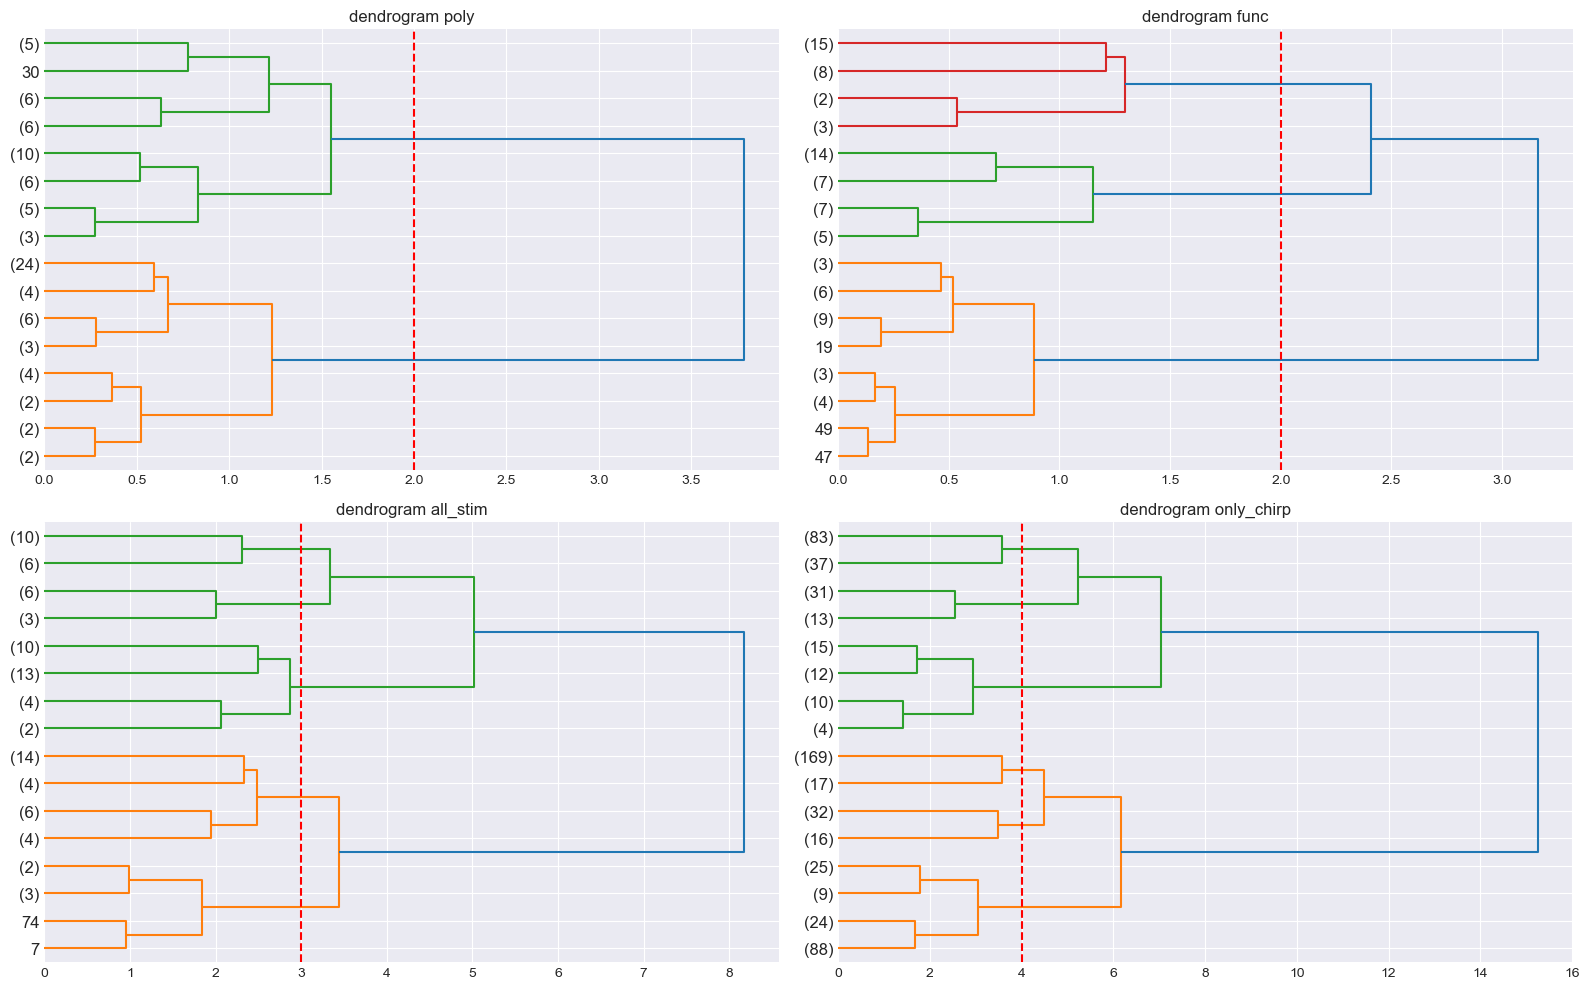

In [11]:
hide_warnings()
columns = 2 if len(dfs_norm) > 1 else 1
rows = int(np.ceil(len(dfs) / columns))
plot_number = 1
figure_size = (columns * 8, rows * 5)
dendrogram_distance_threshold = {
    "poly": 2,
    "func": 2,
    "all_frames": 3,
    "all_stim": 3,
    "only_chirp": 4,
}
_, axs = plt.subplots(ncols=columns, nrows=rows, figsize=figure_size)
for df_name, data in dfs_norm.items():
    subplot_row = (plot_number - 1) // columns
    subplot_column = (plot_number - 1) % columns
    plot_dendrogram(
        title=f"dendrogram {df_name}",
        X=data,
        axs=axs,
        subplot_coords=(subplot_row, subplot_column),
        vertical_line=dendrogram_distance_threshold[df_name],
        truncate_mode="level",
        p=3,
    )
    plot_number += 1
plt.tight_layout()
plt.show()

## Models Parameters

In [12]:
k_means_general_params = {
    "n_init": 1000,
    "max_iter": 20000,
    "tol": 1e-8,
    "random_state": 0,
}

k_means_params = dict()

dbscan_general_params = {
    "min_samples": 3,
}

dbscan_params = dict()

gmm_general_params = {
    "max_iter": 20000,
    "tol": 1e-8,
    "random_state": 0,
}

gmm_params = dict()

hdbscan_general_params = {
    "min_cluster_size": 5,
}

hdbscan_params = dict()

agglomerative_general_params = {
    "linkage": "ward",
    "metric": "euclidean",
    "n_clusters": None,
}

agglomerative_params = dict()

for df_name in dfs.keys():
    # K-Means Params
    k_means_params[df_name] = dict()
    for param, value in k_means_general_params.items():
        k_means_params[df_name][param] = value
    k_means_params[df_name]["n_clusters"] = k_means_n_clusters[df_name]

    # DBSCAN Params
    dbscan_params[df_name] = dict()
    for param, value in dbscan_general_params.items():
        dbscan_params[df_name][param] = value
    dbscan_params[df_name]["eps"] = dbscan_eps[df_name]

    # GMM Params
    gmm_params[df_name] = gmm_general_params
    for param, value in gmm_general_params.items():
        gmm_params[df_name][param] = value
    for param, value in gmm_search_grid[df_name].best_params_.items():
        gmm_params[df_name][param] = value

    # HDBSCAN Params
    hdbscan_params[df_name] = hdbscan_general_params

    # Agglomerative Params
    agglomerative_params[df_name] = dict()
    for param, value in agglomerative_general_params.items():
        agglomerative_params[df_name][param] = value
    agglomerative_params[df_name]["distance_threshold"] = dendrogram_distance_threshold[
        df_name
    ]

clustering_params = dict()
clustering_params["k-means"] = k_means_params
clustering_params["dbscan"] = dbscan_params
clustering_params["gmm"] = gmm_params
clustering_params["hdbscan"] = hdbscan_params
clustering_params["agglomerative"] = agglomerative_params

## Export Data

In [13]:
with open(
    "../../" + config["paths"]["data_cache"]["clustering"]["PARAMS"], "wb"
) as output:
    pickle.dump(clustering_params, output)

___